## install pysgmcmc

In [ ]:
!pip install git+https://github.com/MFreidank/pysgmcmc
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MFreidank/pysgmcmc to /tmp/pip-req-build-zxherv5e
  Running command git clone --filter=blob:none --quiet https://github.com/MFreidank/pysgmcmc /tmp/pip-req-build-zxherv5e
  Resolved https://github.com/MFreidank/pysgmcmc to commit 1fe63570486e2d3f6cc2d3016314a92b96464b00
  Preparing metadata (setup.py) ... done


## import and data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0','1','2','3','4','5','6','7','8','9')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# code retrieved from https://pysgmcmc.readthedocs.io/en/pytorch/_modules/pysgmcmc/optimizers/sgld.html

import torch
from torch.optim import Optimizer


# Pytorch Port of a previous tensorflow implementation in `tensorflow_probability`:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/g3doc/api_docs/python/tfp/optimizer/StochasticGradientLangevinDynamics.md
class SGLD(Optimizer):
    """ Stochastic Gradient Langevin Dynamics Sampler with preconditioning.
        Optimization variable is viewed as a posterior sample under Stochastic
        Gradient Langevin Dynamics with noise rescaled in eaach dimension
        according to RMSProp.
    """
    def __init__(self,
                 params,
                 lr=1e-2,
                 precondition_decay_rate=0.95,
                 num_pseudo_batches=1,
                 num_burn_in_steps=3000,
                 diagonal_bias=1e-8) -> None:
        """ Set up a SGLD Optimizer.

        Parameters
        ----------
        params : iterable
            Parameters serving as optimization variable.
        lr : float, optional
            Base learning rate for this optimizer.
            Must be tuned to the specific function being minimized.
            Default: `1e-2`.
        precondition_decay_rate : float, optional
            Exponential decay rate of the rescaling of the preconditioner (RMSprop).
            Should be smaller than but nearly `1` to approximate sampling from the posterior.
            Default: `0.95`
        num_pseudo_batches : int, optional
            Effective number of minibatches in the data set.
            Trades off noise and prior with the SGD likelihood term.
            Note: Assumes loss is taken as mean over a minibatch.
            Otherwise, if the sum was taken, divide this number by the batch size.
            Default: `1`.
        num_burn_in_steps : int, optional
            Number of iterations to collect gradient statistics to update the
            preconditioner before starting to draw noisy samples.
            Default: `3000`.
        diagonal_bias : float, optional
            Term added to the diagonal of the preconditioner to prevent it from
            degenerating.
            Default: `1e-8`.

        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if num_burn_in_steps < 0:
            raise ValueError("Invalid num_burn_in_steps: {}".format(num_burn_in_steps))

        defaults = dict(
            lr=lr, precondition_decay_rate=precondition_decay_rate,
            num_pseudo_batches=num_pseudo_batches,
            num_burn_in_steps=num_burn_in_steps,
            diagonal_bias=1e-8,
        )
        super().__init__(params, defaults)


    def step(self, closure=None):
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for parameter in group["params"]:

                if parameter.grad is None:
                    continue

                state = self.state[parameter]
                lr = group["lr"]
                num_pseudo_batches = group["num_pseudo_batches"]
                precondition_decay_rate = group["precondition_decay_rate"]
                gradient = parameter.grad.data

                #  State initialization {{{ #

                if len(state) == 0:
                    state["iteration"] = 0
                    state["momentum"] = torch.ones_like(parameter)

                #  }}} State initialization #

                state["iteration"] += 1

                momentum = state["momentum"]

                #  Momentum update {{{ #
                momentum.add_(
                    (1.0 - precondition_decay_rate) * ((gradient ** 2) - momentum)
                )
                #  }}} Momentum update #

                if state["iteration"] > group["num_burn_in_steps"]:
                    sigma = 1. / torch.sqrt(torch.tensor(lr))
                else:
                    sigma = torch.zeros_like(parameter)

                preconditioner = (
                    1. / torch.sqrt(momentum + group["diagonal_bias"])
                )

                scaled_grad = (
                    0.5 * preconditioner * gradient * num_pseudo_batches +
                    torch.normal(
                        mean=torch.zeros_like(gradient),
                        std=torch.ones_like(gradient)
                    ) * sigma * torch.sqrt(preconditioner)
                )

                parameter.data.add_(-lr * scaled_grad)

        return loss

## base model: LeNet5

In [37]:

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        # projection: secret key on user
        '''
        self.hidden = nn.Conv2d(1,1,1,padding='same')
        self.projection = torch.normal(mean=0,std=0.3,size=(28,28)).to(device)
        self.hidden2 = nn.Conv2d(1,1,1,padding='same')
        '''
        # begin of standard LeNet
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()


        self.pool2 = nn.MaxPool2d(2)

        # add some variation so that the similarity is not a significant issue
        self.projection = nn.Linear(256, 256)

        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        '''
        y = self.hidden(x)
        y = y*self.projection
        y = self.hidden2(y)
        '''
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.projection(y)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y


    def partial_eval(self,x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)

        y = y.view(y.shape[0], -1)
        y = self.projection(y)
        return y
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (projection): Linear(in_features=256, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)

In [30]:
#import pysgmcmc

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = SGLD(net.parameters(), lr=0.0001)

In [32]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.286
[2,  1000] loss: 0.781
[3,  1000] loss: 0.383
[4,  1000] loss: 0.326
[5,  1000] loss: 0.259
[6,  1000] loss: 0.077
[7,  1000] loss: 0.061
[8,  1000] loss: 0.057
[9,  1000] loss: 0.050
[10,  1000] loss: 0.044
Finished Training


In [33]:
PATH = './LeNet.pth'
#projection_weight_path = './LeNet_pr.pth'
torch.save(net.state_dict(), PATH)
#torch.save(net.projection, projection_weight_path)

In [38]:
PATH = './LeNet.pth'
#projection_weight_path = './LeNet_pr.pth'
net = LeNet5().to(device)
net.load_state_dict(torch.load(PATH))
#net.projection = torch.load(projection_weight_path)

<All keys matched successfully>

In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.9835


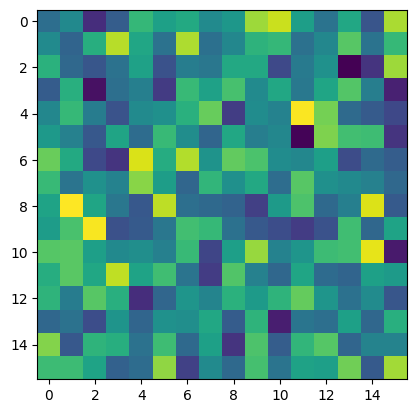

In [45]:
'''
no need to show, dimension size already changed
img_compare = (trainset[0][0])[None,:,:,:].cuda()
ori = net.partial_eval(img_compare)
def imshow(img):
    img = img.reshape((1,16,16))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(ori.detach().cpu())
'''

## NN decryption

In [95]:
class LeNet_decrypt(nn.Module):

    def __init__(self):
        super(LeNet_decrypt, self).__init__()
        self.enc1 = nn.Conv2d(1,6,3,padding='same')
        self.enc2 = nn.Conv2d(6,16,3,padding='same')
        self.enc3 = nn.Conv2d(16,6,3,padding='same')
        self.enc4 = nn.Conv2d(6,1,3,padding='same')
        self.relu1 = nn.ReLU()
        '''
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        '''
        self.match_size = nn.Linear(28*28, 256)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.enc1(x)
        y = self.relu1(y)
        y = self.enc2(y)
        y = self.relu1(y)
        y = self.enc3(y)
        y = self.relu1(y)
        y = self.enc4(y)
        y = self.relu1(y)
        '''
        y = self.conv1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        '''
        y = y.view(y.shape[0], -1)
        y = self.match_size(y)
        y = self.relu1(y)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y
    def partial_eval(self,x):
        y = self.fc1(x)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y
    def partial_eval_enc(self,x):
        y = self.enc1(x)
        y = self.relu1(y)
        y = self.enc2(y)
        y = self.relu1(y)
        y = self.enc3(y)
        y = self.relu1(y)
        y = self.enc4(y)
        y = self.relu1(y)
        '''
        y = self.conv1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        '''
        y = y.view(y.shape[0], -1)
        y = self.match_size(y)
        y = self.relu1(y)
        return y

net_decrypt = LeNet_decrypt()
for param in net_decrypt.parameters():
    param.requires_grad = False

net_decrypt.enc1.weight.requires_grad = True
net_decrypt.enc2.weight.requires_grad = True
net_decrypt.enc3.weight.requires_grad = True
net_decrypt.enc4.weight.requires_grad = True
net_decrypt.match_size.weight.requires_grad = True
net_decrypt.enc1.bias.requires_grad = True
net_decrypt.enc2.bias.requires_grad = True
net_decrypt.enc3.bias.requires_grad = True
net_decrypt.enc4.bias.requires_grad = True
net_decrypt.match_size.bias.requires_grad = True
#net.enc1 = nn.Conv2d(1,6,3,padding='same')
#net.enc2 = nn.Conv2d(6,16,3,padding='same')
#net.enc3 = nn.Conv2d(6,16,3,padding='same')
#net.enc4 = nn.Conv2d(16,1,3,padding='same')

net_decrypt.to(device)

LeNet_decrypt(
  (enc1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc3): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc4): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (match_size): Linear(in_features=784, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)

In [82]:
for param in net_decrypt.parameters():
  print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False


In [96]:
PATH = './LeNet.pth'
net_decrypt.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_decrypt.parameters(), lr=0.001, momentum=0.9)

four layer encoder CANNOT approximate the gaussian kernel

In [85]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decrypt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.043


KeyboardInterrupt: ignored

In [ ]:
PATH = './LeNet_decrypt.pth'

torch.save(net_decrypt.state_dict(), PATH)

In [142]:
PATH = './LeNet_decrypt.pth'

net_decrypt.load_state_dict(torch.load(PATH), strict=False)

<All keys matched successfully>

In [143]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        outputs = net_decrypt.partial_eval(intermediate)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.9835


### try 6 layer

In [68]:
class LeNet_decrypt(nn.Module):

    def __init__(self):
        super(LeNet_decrypt, self).__init__()
        self.enc1 = nn.Conv2d(1,6,3,padding='same')
        self.enc2 = nn.Conv2d(6,16,3,padding='same')
        self.enc3 = nn.Conv2d(16,32,3,padding='same')
        self.enc4 = nn.Conv2d(32,16,3,padding='same')
        self.enc5 = nn.Conv2d(16,6,3,padding='same')
        self.enc6 = nn.Conv2d(6,1,3,padding='same')
        self.relu1 = nn.ReLU()
        '''
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        '''
        self.match_size = nn.Linear(28*28, 256)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.enc1(x)
        y = self.relu1(y)
        y = self.enc2(y)
        y = self.relu1(y)
        y = self.enc3(y)
        y = self.relu1(y)
        y = self.enc4(y)
        y = self.relu1(y)
        y = self.enc5(y)
        y = self.relu1(y)
        y = self.enc6(y)
        y = self.relu1(y)
        '''
        y = self.conv1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        '''

        y = y.view(y.shape[0], -1)
        y = self.match_size(y)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

net_decrypt = LeNet_decrypt()
for param in net_decrypt.parameters():
    param.requires_grad = False

net_decrypt.enc1.weight.requires_grad = True
net_decrypt.enc2.weight.requires_grad = True
net_decrypt.enc3.weight.requires_grad = True
net_decrypt.enc4.weight.requires_grad = True
net_decrypt.enc5.weight.requires_grad = True
net_decrypt.enc6.weight.requires_grad = True
net_decrypt.enc1.bias.requires_grad = True
net_decrypt.enc2.bias.requires_grad = True
net_decrypt.enc3.bias.requires_grad = True
net_decrypt.enc4.bias.requires_grad = True
net_decrypt.enc5.bias.requires_grad = True
net_decrypt.enc6.bias.requires_grad = True
#net.enc1 = nn.Conv2d(1,6,3,padding='same')
#net.enc2 = nn.Conv2d(6,16,3,padding='same')
#net.enc3 = nn.Conv2d(6,16,3,padding='same')
#net.enc4 = nn.Conv2d(16,1,3,padding='same')

net_decrypt.to(device)

LeNet_decrypt(
  (enc1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc5): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (enc6): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (match_size): Linear(in_features=784, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)

In [69]:
PATH = './LeNet.pth'
net_decrypt.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_decrypt.parameters(), lr=0.001, momentum=0.9)

In [70]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decrypt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.308
[2,  1000] loss: 2.307
[3,  1000] loss: 2.308
[4,  1000] loss: 2.308
[5,  1000] loss: 2.308
[6,  1000] loss: 2.307
[7,  1000] loss: 2.304
[8,  1000] loss: 2.267
[9,  1000] loss: 2.015
[10,  1000] loss: 1.609
[11,  1000] loss: 1.093
[12,  1000] loss: 0.728
[13,  1000] loss: 0.590
[14,  1000] loss: 0.490
[15,  1000] loss: 0.447
[16,  1000] loss: 0.404
[17,  1000] loss: 0.366
[18,  1000] loss: 0.345
[19,  1000] loss: 0.328
[20,  1000] loss: 0.309
[21,  1000] loss: 0.293
[22,  1000] loss: 0.285
[23,  1000] loss: 0.269
[24,  1000] loss: 0.261
[25,  1000] loss: 0.255
[26,  1000] loss: 0.248
[27,  1000] loss: 0.233
[28,  1000] loss: 0.229
[29,  1000] loss: 0.219
[30,  1000] loss: 0.214
[31,  1000] loss: 0.214
[32,  1000] loss: 0.205
[33,  1000] loss: 0.199
[34,  1000] loss: 0.200
[35,  1000] loss: 0.189
[36,  1000] loss: 0.181
[37,  1000] loss: 0.180
[38,  1000] loss: 0.173
[39,  1000] loss: 0.177
[40,  1000] loss: 0.175
[41,  1000] loss: 0.163
[42,  1000] loss: 0.166
[

In [71]:
PATH = './LeNet_decrypt.pth'

torch.save(net_decrypt.state_dict(), PATH)

In [72]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.9835


### decoder

In [148]:
class LeNet_decoder(nn.Module):

    def __init__(self):
        super(LeNet_decoder, self).__init__()
        '''
        self.enc1 = nn.Conv2d(1,6,3,padding='same')
        self.enc2 = nn.Conv2d(6,16,3,padding='same')
        self.enc3 = nn.Conv2d(16,6,3,padding='same')
        self.enc4 = nn.Conv2d(6,1,3,padding='same')
        self.relu1 = nn.ReLU()
        self.match_size = nn.Linear(28*28, 256)
        '''
        self.relu1 = nn.ReLU()

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_match_size = nn.Linear(256, 28*28)
        '''
        self.t_conv1 = nn.ConvTranspose2d(1, 6, 3, padding=(1,1))
        self.t_conv2 = nn.ConvTranspose2d(6, 16, 3, padding=(1,1))
        self.t_conv3 = nn.ConvTranspose2d(16, 6, 3, padding=(1,1))
        self.t_conv4 = nn.ConvTranspose2d(6, 1, 3, padding=(1,1))
        '''
        self.t_conv1 = nn.Conv2d(1,6,3,padding='same')
        self.t_conv2 = nn.Conv2d(6,16,3,padding='same')
        self.t_conv3 = nn.Conv2d(16,6,3,padding='same')
        self.t_conv4 = nn.Conv2d(6,1,3,padding='same')

    def forward(self, x):
        '''
        y = self.enc1(x)
        y = self.relu1(y)
        y = self.enc2(y)
        y = self.relu1(y)
        y = self.enc3(y)
        y = self.relu1(y)
        y = self.enc4(y)
        y = self.relu1(y)


        y = self.conv1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)

        y = self.match_size(y)
        y = y.view(y.shape[0], -1)

        y = self.relu1(y)
        '''
        y = self.t_match_size(x)
        y = self.relu1(y)

        y = torch.reshape(y,[y.shape[0],1,28,28])
        y = self.t_conv1(y)
        y = self.relu1(y)
        y = self.t_conv2(y)
        y = self.relu1(y)
        y = self.t_conv3(y)
        y = self.relu1(y)
        y = self.t_conv4(y)
        #y = self.relu1(y)
        return y
    '''
    def partial_eval(self,x):
        y = self.t_match_size(x)
        y = self.relu1(y)
        y = torch.reshape(y,[y.shape[0],y.shape[1],28,28])
        y = self.t_conv1(y)
        y = self.relu1(y)
        y = self.t_conv2(y)
        y = self.relu1(y)
        y = self.t_conv3(y)
        y = self.relu1(y)
        y = self.t_conv4(y)
        y = self.relu1(y)
        return y
    '''
net_decoder = LeNet_decoder()
'''
for param in net_decoder .parameters():
    param.requires_grad = False

net_decoder.t_match_size.weight.requires_grad = True
net_decoder.t_conv1.weight.requires_grad = True
net_decoder.t_conv2.weight.requires_grad = True
net_decoder.t_conv3.weight.requires_grad = True
net_decoder.t_conv4.weight.requires_grad = True
net_decoder.t_match_size.bias.requires_grad = True
net_decoder.t_conv1.bias.requires_grad = True
net_decoder.t_conv2.bias.requires_grad = True
net_decoder.t_conv3.bias.requires_grad = True
net_decoder.t_conv4.bias.requires_grad = True
#net.enc1 = nn.Conv2d(1,6,3,padding='same')
#net.enc2 = nn.Conv2d(6,16,3,padding='same')
#net.enc3 = nn.Conv2d(6,16,3,padding='same')
#net.enc4 = nn.Conv2d(16,1,3,padding='same')
'''
net_decoder.to(device)

LeNet_decoder(
  (relu1): ReLU()
  (t_match_size): Linear(in_features=256, out_features=784, bias=True)
  (t_conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (t_conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (t_conv3): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (t_conv4): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
)

In [149]:
'''
PATH = './LeNet_decrypt.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)
'''

"\nPATH = './LeNet_decrypt.pth'\nnet_decoder.load_state_dict(torch.load(PATH), strict=False)\ncriterion = nn.MSELoss()\noptimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)\n"

In [150]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)

In [151]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #outputs = net_decrypt.partial_eval_enc(inputs)
        outputs = net.partial_eval(inputs)
        outputs = net_decoder(outputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430><function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only te

[1,  1000] loss: 0.393


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

[2,  1000] loss: 0.230


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

[3,  1000] loss: 0.168


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430><function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

[4,  1000] loss: 0.131


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

[5,  1000] loss: 0.113


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorself._shutdown_workers(): can only test a child process

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[6,  1000] loss: 0.100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only te

[7,  1000] loss: 0.092


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/p

[8,  1000] loss: 0.086


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

[9,  1000] loss: 0.081


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430><function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

[10,  1000] loss: 0.078


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():        
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only te

[11,  1000] loss: 0.074


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

[12,  1000] loss: 0.071


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

AssertionError    : can only test a child process
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[13,  1000] loss: 0.068


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>    
assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     can only test a child process
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[14,  1000] loss: 0.066


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():    self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: if w.is_alive():can only test a child process
  File "/usr/lib/p

[15,  1000] loss: 0.065


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fceafe4c430>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError    : can only test a child process
if w.is_alive():
  File "/usr/lib/

[16,  1000] loss: 0.063
[17,  1000] loss: 0.061
[18,  1000] loss: 0.060
[19,  1000] loss: 0.058
[20,  1000] loss: 0.057
[21,  1000] loss: 0.056
[22,  1000] loss: 0.055
[23,  1000] loss: 0.054
[24,  1000] loss: 0.053
[25,  1000] loss: 0.053
[26,  1000] loss: 0.052
[27,  1000] loss: 0.051
[28,  1000] loss: 0.051
[29,  1000] loss: 0.050
[30,  1000] loss: 0.049
[31,  1000] loss: 0.048
[32,  1000] loss: 0.048
[33,  1000] loss: 0.047
[34,  1000] loss: 0.047
[35,  1000] loss: 0.046
[36,  1000] loss: 0.046
[37,  1000] loss: 0.046
[38,  1000] loss: 0.045
[39,  1000] loss: 0.045
[40,  1000] loss: 0.044
[41,  1000] loss: 0.044
[42,  1000] loss: 0.044
[43,  1000] loss: 0.043
[44,  1000] loss: 0.043
[45,  1000] loss: 0.043
[46,  1000] loss: 0.042
[47,  1000] loss: 0.042
[48,  1000] loss: 0.042
[49,  1000] loss: 0.041
[50,  1000] loss: 0.041
Finished Training


In [127]:
img_compare = trainset[0][0].cuda()

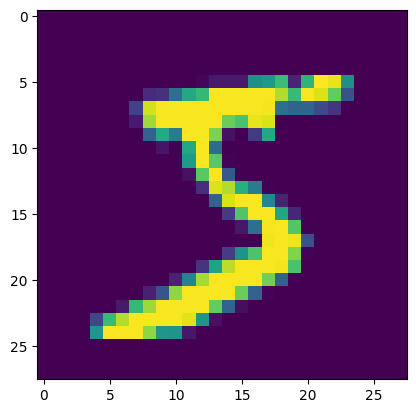

In [152]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img_compare.detach().cpu())

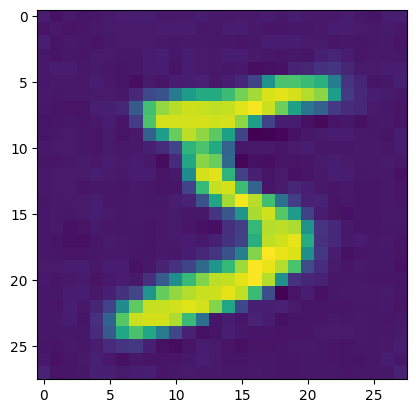

In [153]:
target = img_compare[None,:,:,:]
result = net_decoder(net.partial_eval(target))
imshow(result[0].detach().cpu())

## comparison

In [ ]:
img_compare = trainset[0][0].cuda()


In [ ]:
PATH = './LeNet.pth'
projection_weight_path = './LeNet_pr.pth'

net = LeNet5().to(device)
net.load_state_dict(torch.load(PATH))
net.projection = torch.load(projection_weight_path)

projection_mat = torch.load(projection_weight_path)

ori = net.hidden(img_compare)
ori = ori*projection_mat
ori = net.hidden2(ori)
print(ori)

tensor([[[-2.0313e+00,  3.5191e+00,  1.3012e+00,  2.3335e+00,  2.0149e+00,
           8.3257e-01, -6.9931e+00,  3.0224e+00,  4.2172e+00,  2.2016e+00,
          -4.5453e-02, -2.9104e-01,  3.2459e+00, -2.6204e+00,  4.1621e+00,
           2.1269e+00,  2.4023e+00, -2.8152e+00,  5.8787e+00,  1.7042e+00,
          -1.1819e+00, -1.5931e+00,  3.3642e+00,  2.3367e+00, -3.8447e-01,
           7.1397e+00,  6.2738e+00, -2.5707e+00],
         [ 4.1105e+00,  3.8006e+00, -1.6139e+00, -1.3959e+00,  2.3309e+00,
           2.9772e+00, -2.4847e+00,  6.3285e+00,  7.5595e+00, -1.7872e+00,
          -6.9106e-01, -9.2968e-01, -3.3776e+00,  4.4537e+00, -4.2214e-01,
           1.7103e+00, -3.4774e+00, -5.3715e+00,  8.6126e+00, -7.6284e-01,
           2.2619e+00,  3.2579e+00, -1.7163e+00,  1.7300e+00, -9.4891e-01,
           1.1530e+00, -4.5225e-01,  1.0818e+00],
         [-2.8740e-01,  6.5593e-01,  4.0486e+00, -4.5363e-01,  9.8850e-01,
          -6.4309e+00, -2.7005e+00,  1.5445e+00,  1.9291e+00,  2.5287e+00,


In [ ]:
PATH = './LeNet_decrypt.pth'
net_decrypt.load_state_dict(torch.load(PATH))

dec = net_decrypt.enc1(img_compare)
dec = net_decrypt.enc2(dec)
dec = net_decrypt.enc3(dec)
dec = net_decrypt.enc4(dec)
dec = net_decrypt.enc5(dec)
dec = net_decrypt.enc6(dec)
print(dec)

tensor([[[ 7.0381e+00, -1.1629e+00,  3.8345e+01,  9.2254e+00, -4.6151e+01,
          -4.2198e+00, -1.3872e+00, -1.8692e+00, -1.9724e+00, -1.6840e+00,
          -1.4267e+00, -1.4421e+00, -1.2746e+00, -1.2172e+00, -7.6697e-01,
          -9.7963e-01, -6.7877e-01, -1.1321e+00, -3.2419e-01,  7.2358e-01,
           2.0250e+00,  2.0847e+00, -1.2030e+00,  7.1379e+00,  1.9256e+00,
          -9.7951e+00,  4.5128e+00,  4.8784e-01],
         [ 4.6978e+01, -1.4630e+01,  1.7290e+01,  3.6085e+01,  1.9553e+01,
          -8.9401e+00, -1.1318e+01, -1.0849e+01, -1.0468e+01, -1.0218e+01,
          -9.9266e+00, -1.0041e+01, -1.0039e+01, -1.0096e+01, -8.4117e+00,
          -7.2283e+00, -7.4955e+00, -7.5907e+00, -7.3516e+00, -8.1173e+00,
          -8.6226e+00, -8.8532e+00, -1.0503e+01, -8.4587e+00,  1.0865e+01,
          -2.2533e+01, -1.3014e+01, -2.2636e+01],
         [ 3.2354e+01,  2.3438e+01,  2.0858e+01,  1.3343e+00, -9.0910e+00,
          -7.9857e+00, -5.1173e+00, -4.6589e+00, -3.6618e+00, -2.9878e+00,


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



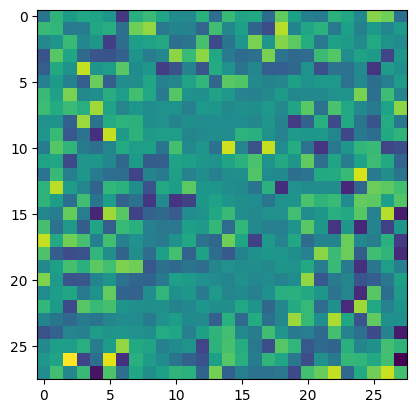

In [ ]:

imshow(ori.detach().cpu())

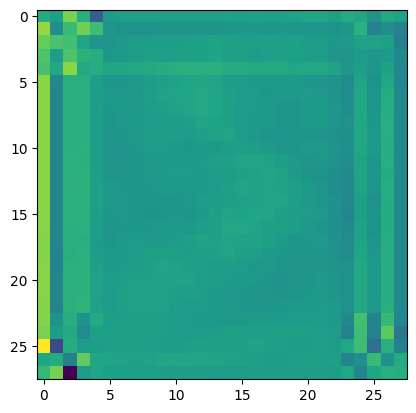

In [ ]:
imshow(dec.detach().cpu())

## store data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/LeNet.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_decrypt.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_pr.pth /content/drive/MyDrive/security_weight

### additional